In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import string
from nltk.corpus import stopwords
import nltk
import huspacy
import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import seaborn as sns
import gensim
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import time

In [79]:
start_time = time.time()

## 3.1. Data Preprocessing

Reading in the files as list of strings with each element of the list being a document

In [80]:
# old documents (before the 16th century)
old_files = [f for f in os.listdir('../data/old') if f.endswith('.txt')]
old_documents = []
for filename in old_files:
    with open(os.path.join('../data/old',filename),'r',encoding='utf-8') as f:
        old_documents.append(f.read())

# new documents (from 20th century)
new_files = [f for f in os.listdir('../data/new') if f.endswith('.txt')]
new_documents = []
for filename in new_files:
    with open(os.path.join('../data/new',filename),'r',encoding='utf-8') as f:
        new_documents.append(f.read())

In [81]:
# inspecting the results of reading in the files
print("An example document in old Hungarian:")
print(old_documents[8])
print("------------------------------------------")
print("An example document from the 20th century:")
print(new_documents[10])

An example document in old Hungarian:
Krisztus feltámada , mint ön nagy kínjából asszony , mi is örülünk .
Krisztus legyen reményünk .
Kyrie eleison 
------------------------------------------
An example document from the 20th century:
Nincsen apám, se anyám,
se istenem, se hazám,
se bölcsőm, se szemfedőm,
se csókom, se szeretőm.

Harmadnapja nem eszek,
se sokat, se keveset.
Húsz esztendőm hatalom,
húsz esztendőm eladom.

Hogyha nem kell senkinek,
hát az ördög veszi meg.
Tiszta szívvel betörök,
ha kell, embert is ölök.

Elfognak és felkötnek,
áldott földdel elfödnek
s halált hozó fű terem
gyönyörűszép szívemen.


In [82]:
# only needs to be run once, download time: 2m 48.4s
nltk.download("stopwords")
huspacy.download()

['c:\\ProgramData\\anaconda3\\python.exe', '-m', 'pip', 'install', 'hu_core_news_lg @ https://huggingface.co/huspacy/hu_core_news_lg/resolve/v3.8.0/hu_core_news_lg-any-py3-none-any.whl']


[nltk_data] Downloading package stopwords to C:\Users\Kim
[nltk_data]     Levente\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [83]:
def TextPreprocessor(text, nlp):
    """ Preprocesses documents

    Parameters
    ----------
    text string, document to be cleaned
    nlp Spacy Language, pipeline for tokenization
    
    Returns
    -------
    text_clean string, cleaned document
    """
    # make text lowercase, replace linebreak with space
    text_low = text.lower()
    text_low = text_low.replace("\n"," ")

    # some texts contain indicators of which line the text is at
    # in curly brackets
    text_low = re.sub(r'\{[^}]*\}', '', text_low)

    # tokenize the document
    tokens = [token.text for token in nlp(text_low)]
    
    # exclude stopwords and punctuations
    stop_words = set(stopwords.words("Hungarian"))
    tokens_clean = [word for word in tokens if word not in stop_words and word not in string.punctuation]

    # cleaned tokens are joined by space
    text_clean = " ".join(tokens_clean)

    return text_clean

In [84]:
# clean texts, runtime: < 20s
nlp_hun = huspacy.load()
old_docs_clean = [TextPreprocessor(doc,nlp_hun) for doc in old_documents]
new_docs_clean = [TextPreprocessor(doc,nlp_hun) for doc in new_documents]

Inspecting the result of preprocessing an old text and a new one

In [85]:
print(old_documents[4])
print("--------------")
print(old_docs_clean[4])

ez vég pusztaságról megemlékeznétek , el ne vesznétek , az régi jó nevet megelevenítenétek , kereszténységnek jó vértei  lennétek .
szegény Mátyás király vala békességben , mert országa vala egyességben , vitézek valának nála tisztességben , az urak valának nagy egyenességben .
ti Úristen ellen ne háborganátok , régi dekrétumot csak megtartanátok , az dézsmát igazán kiszolgáltatnátok , koronként Istennek vele áldoznátok .
Isten , Szűz Mária háborútól védjen , Hatvanban gyűlétek , hogy jó végre legyen , jó Lajos királyunk diadalmat vegyen , minden tanácsotokban ő jó véget tegyen .
Pesti Beke Ferenc szíve kétségében , ki az vendég népnek bízik erejében , török császárt töri hízelkedésében , minden ennek ő elvetett beszédében .
Geszti László diák szerzé ez éneket , Magyarország vala nagy fő szükségében , az végek valának mind elveszendőben , ezerötszázhuszonöt esztendőben .
--------------
vég pusztaságról megemlékeznétek vesznétek régi nevet megelevenítenétek kereszténységnek vértei   len

In [86]:
print(new_documents[4])
print("--------------")
print(new_docs_clean[4])

Haragszom én arra szóra,
Ki a papot úgy megszólja,
Mert a papnak nincs bundája,
Hideg a reverendája.
Heje-huja, hopp!
Haragszom én arra szóra,
Ki a mestert úgy megszólja;
A mesternek nincs kalapja,
Sapkában jár az utcára.
Heje-huja, hopp!
Heje-huja, szűröm ujja!
A cigány a nótám fújja.
Gyere, rózsám, táncoljunk hát,
Járjuk el a magyar nótát!
Heje-huja, hopp!
--------------
haragszom szóra papot megszólja papnak bundája hideg reverendája heje-huja hopp haragszom szóra mestert megszólja mesternek kalapja sapkában jár utcára heje-huja hopp heje-huja szűröm ujja cigány nótám fújja gyere rózsám táncoljunk hát járjuk magyar nótát heje-huja hopp


In [87]:
# get example stop words in Hungarian
stopwords.words("Hungarian")[0:20]

['a',
 'ahogy',
 'ahol',
 'aki',
 'akik',
 'akkor',
 'alatt',
 'által',
 'általában',
 'amely',
 'amelyek',
 'amelyekben',
 'amelyeket',
 'amelyet',
 'amelynek',
 'ami',
 'amit',
 'amolyan',
 'amíg',
 'amikor']

In [88]:
# join the lists of cleaned docs for further analysis
docs_clean = old_docs_clean + new_docs_clean

## 3.2. Embedding Models
### 1. Count Vectorization

In [89]:
vectorizer1 = CountVectorizer(min_df=3)
X1_sparse = vectorizer1.fit_transform(docs_clean)

# for further analysis, the result is converted to np array
X1 = X1_sparse.toarray()

In [90]:
# check results of count vectorization
res1 = pd.DataFrame(X1,
             columns=vectorizer1.get_feature_names_out())
res1.iloc[0:5,6:15]

,egyet,egyszer,előtt,ember,engem,engemet,esztendőben,fa,fia
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,3,0,0,0
2,0,0,1,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0


### 2.TF-IDF Vectorization

In [91]:
vectorizer2 = TfidfVectorizer(min_df=3)
X2_sparse = vectorizer2.fit_transform(docs_clean)

# for further analysis, the result is converted to np array
X2 = X2_sparse.toarray()

In [92]:
# check results
res2 = pd.DataFrame(X2,
             columns=vectorizer2.get_feature_names_out())
res2.head()

,adatott,anya,asszony,avagy,bús,császár,egyet,egyszer,előtt,ember,...,énnekem,értem,ím,óriás,ön,ördög,úr,út,ők,őt
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.098056,0.00000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.251926,0.0,0.0,0.000000,0.00000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.065377,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.39226,0.116993
3,0.0,0.0,0.0,0.0,0.0,0.147517,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000


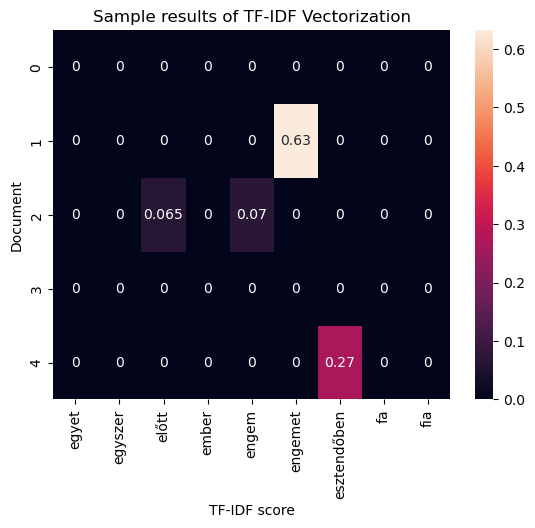

In [93]:
sns.heatmap(res2.iloc[0:5,6:15],annot=True)
plt.title("Sample results of TF-IDF Vectorization")
plt.xlabel("TF-IDF score")
plt.ylabel("Document")
plt.show()

### 3.Word2Vec

Tokenize documents

In [94]:
tokens = []
for doc in docs_clean:
    tokens_doc = [token.text for token in nlp_hun(doc)]
    tokens.append(tokens_doc)

In [95]:
# due to small vocabulary, SkipGram is used
model3 = gensim.models.Word2Vec(tokens, min_count=3,
                                vector_size=500, window=5,
                                sg=1)

To obtain a vector for each document, the average vector is taken for each document

In [96]:
def doc_to_vec(doc, model, nlp):
    """ Create vectorization of document

    Parameters
    ----------
    doc string, document
    model gensim model, trained Gensim embedding model
    nlp Spacy Language, pipeline for tokenization
    """
    doc_tokenized = [token.text for token in nlp(doc)]
    vectors_doc = [model.wv[word] for word in doc_tokenized if word in model.wv]
    if vectors_doc:
        return np.mean(vectors_doc,axis=0)
    else:
        return np.zeros(model.vector_size)

In [97]:
X3 = np.array([doc_to_vec(doc, model3, nlp_hun) for doc in docs_clean])

In [98]:
# check results
res3 = pd.DataFrame(X3)
res3.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.002824,0.018173,0.016433,0.006866,-0.009283,-0.020047,0.003125,0.033045,-0.000075,-0.001999,...,0.004264,0.006127,0.023666,-0.010159,0.009294,0.000529,-0.020068,-0.015019,-0.002165,-0.007002
1,0.002908,0.017326,0.015403,0.006104,-0.007318,-0.018621,0.003073,0.031527,0.000105,-0.001846,...,0.003928,0.005593,0.022424,-0.010221,0.007667,0.000485,-0.018981,-0.014105,-0.001835,-0.006084
2,0.002369,0.015496,0.013742,0.005233,-0.007252,-0.016629,0.002508,0.028128,0.000575,-0.001480,...,0.003355,0.005412,0.020166,-0.008956,0.007843,0.000881,-0.017040,-0.012768,-0.001766,-0.005920
3,0.002591,0.018100,0.016828,0.005630,-0.009521,-0.020455,0.003708,0.034088,-0.000440,-0.001975,...,0.003900,0.006810,0.024329,-0.010514,0.009705,0.000468,-0.020988,-0.014986,-0.002249,-0.006880
4,0.003210,0.020072,0.018582,0.006959,-0.010264,-0.022611,0.003800,0.037137,0.000314,-0.001923,...,0.004724,0.007256,0.026730,-0.011148,0.010413,0.000835,-0.021977,-0.016780,-0.002300,-0.007524


## 3.3. Description of Classification Models and Results
### Logistic Regression

In [99]:
# target is defined as 1 if old and 0 otherwise
y = np.array((len(old_documents)*[1]) + (len(new_documents)*[0]))

In [100]:
input_matrices = [X1,X2,X3]
embedding = ["CountVectorizer","TF-IDF","Word2Vec"]

for i in range(len(input_matrices)):
    X = input_matrices[i]

    # split to training and test sample
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        test_size=0.3,
                                                        random_state=2026)
    
    # fit logistic regression
    log_reg = sm.GLM(y_train,X_train,
                     family=sm.families.Binomial())
    log_reg_model = log_reg.fit()

    # the threshold used here is 0.5
    y_pred = log_reg_model.predict(X_test) > 0.5
    acc = round(accuracy_score(y_test,y_pred)*100,4)
    print(f"The out-of-sample accuracy using {embedding[i]} is {acc}%")

The out-of-sample accuracy using CountVectorizer is 78.5714%
The out-of-sample accuracy using TF-IDF is 85.7143%
The out-of-sample accuracy using Word2Vec is 85.7143%


### KNN (K-nearest neighbours algorithm)

In [101]:
input_matrices = [X1,X2,X3]
embedding = ["CountVectorizer","TF-IDF","Word2Vec"]

for i in range(len(input_matrices)):
    X = input_matrices[i]

    # split to training and test sample
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        test_size=0.3,
                                                        random_state=2026)
    
    # fit model
    knn = KNeighborsClassifier(n_neighbors=3)
    knn_model = knn.fit(X_train,y_train)

    y_pred = knn_model.predict(X_test)
    acc = round(accuracy_score(y_test,y_pred)*100,4)
    print(f"The out-of-sample accuracy using {embedding[i]} is {acc}%")

The out-of-sample accuracy using CountVectorizer is 71.4286%
The out-of-sample accuracy using TF-IDF is 85.7143%
The out-of-sample accuracy using Word2Vec is 71.4286%


## 4.1. Analysis of Out-of-sample Performance Differences

Get example words which are only in the Old Hungarian texts

In [102]:
old_tfidf_sums = res2.iloc[0:23].sum(axis=0)
new_tfidf_sums = res2.iloc[24:].sum(axis=0)

# words which are not in modern Hungarian texts and are only in Old Hungarian documents
for word in old_tfidf_sums.index[0:70]:
    if old_tfidf_sums[word] > 0 and new_tfidf_sums[word] == 0:
        print(word)

asszony
császár
előtt
esztendőben
földön
hallá
hiszek
hozzád
hét
igaz
istennek
istentől
jános
király
királynak
krisztus
leszen
lőn
miatt
minket
miá
mondá
mária
mátyás


Creating a visualization of the embedding models using PCA

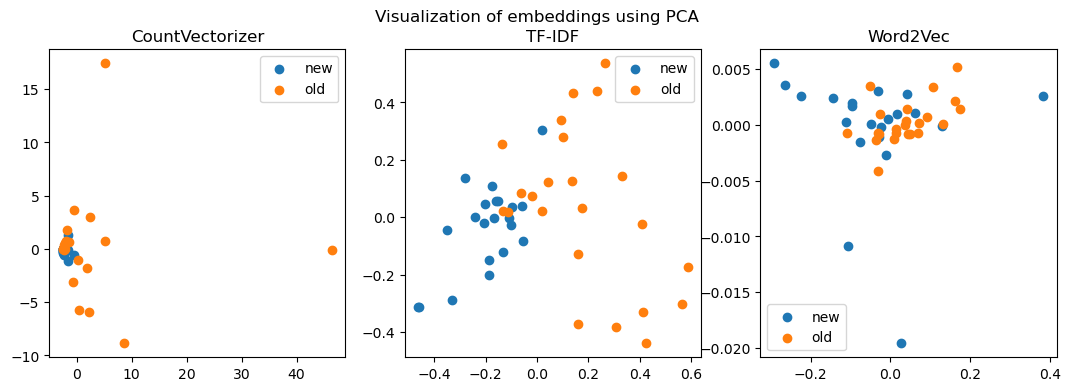

In [103]:
input_matrices = [X1,X2,X3]
embedding = ["CountVectorizer","TF-IDF","Word2Vec"]

# initialize plot
fig = plt.figure(figsize=(13,4))

for i in range(len(input_matrices)):
    # fit PCA using 2 principal components
    pca = PCA(n_components=2,
              random_state=2026)
    
    princ_comps = pca.fit_transform(input_matrices[i])
    pc1 = princ_comps[:, 0]
    pc2 = princ_comps[:, 1]

    # create sub-plot
    ax = fig.add_subplot((131 + i))
    ax.scatter(pc1[np.where(y==0)[0]],
                pc2[np.where(y==0)[0]],
                label='new')
    ax.scatter(pc1[np.where(y==1)[0]],
                pc2[np.where(y==1)[0]],
                label='old')
    ax.set_title(embedding[i])
    ax.legend()

plt.suptitle("Visualization of embeddings using PCA")
plt.show()

In [104]:
print(f"The total runtime is {round(time.time()-start_time,2)}s.")

The total runtime is 126.26s.
